In [80]:

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import tensorflow_datasets as tfds
import keras
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape

Train Shape: (50000, 32, 32, 3),Test Shape: (10000, 32, 32, 3)


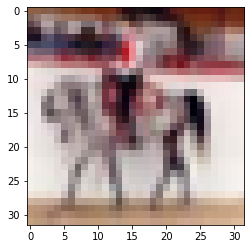

In [81]:

xtrain , ytrain = tfds.as_numpy(tfds.load('cifar10',split='train',batch_size=-1,as_supervised=True,))
xtest , ytest = tfds.as_numpy(tfds.load('cifar10',split='test',batch_size=-1,as_supervised=True,))
xtrain = (xtrain.astype('float32'))/255
xtest = (xtest.astype('float32'))/255

height=32
width=32
channels=3
print(f"Train Shape: {xtrain.shape},Test Shape: {xtest.shape}")
plt.imshow(xtrain[0])

In [82]:
input_shape=(height,width,channels)
latent_dims=3072

input_img= Input(shape=input_shape, name='encoder_input')
x=Conv2D(128, 4, padding='same', activation='relu',strides=2)(input_img)
x=Conv2D(256, 4, padding='same', activation='relu',strides=2)(x)
x=Conv2D(512, 4, padding='same', activation='relu',strides=2)(x)
x=Conv2D(1024, 4, padding='same', activation='relu',strides=2)(x)
conv_shape = K.int_shape(x)
x=Flatten()(x)
x=Dense(3072, activation='relu')(x)
z_mean=Dense(latent_dims, name='latent_mean')(x)
z_sigma=Dense(latent_dims, name='latent_sigma')(x)


In [83]:
def sampler(args):
  z_mean, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
  return z_mean + K.exp(z_sigma / 2) * eps


In [84]:
z = Lambda(sampler, output_shape=(latent_dims, ), name='z')([z_mean, z_sigma])

encoder = Model(input_img, [z_mean, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 16, 16, 128)  6272        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 8, 8, 256)    524544      conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 4, 4, 512)    2097664     conv2d_43[0][0]                  
____________________________________________________________________________________________

In [85]:
decoder_input = Input(shape=(latent_dims, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(256, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(128, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(3, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()
z_decoded = decoder(z)


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 3072)]            0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)              12587008  
_________________________________________________________________
reshape_6 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 4, 4, 256)         2359552   
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 8, 8, 128)         295040    
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 32, 32, 3)         1731

In [86]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mean) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [87]:
y = CustomLayer()([input_img, z_decoded])

vae = Model(input_img, y, name='vae')
vae.compile(optimizer='adam', loss=None)
vae.summary()


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 16, 16, 128)  6272        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 8, 8, 256)    524544      conv2d_42[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 4, 4, 512)    2097664     conv2d_43[0][0]                  
________________________________________________________________________________________________

In [88]:
history=vae.fit(xtrain, verbose=2, epochs = 100, batch_size = 64, validation_split = 0.2)


Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 - 38s - loss: 0.6385 - val_loss: 0.6098
Epoch 2/100
40000/40000 - 34s - loss: 0.6033 - val_loss: 0.5995
Epoch 3/100
40000/40000 - 34s - loss: 0.5972 - val_loss: 0.5948
Epoch 4/100
40000/40000 - 35s - loss: 0.5938 - val_loss: 0.5935
Epoch 5/100
40000/40000 - 35s - loss: 0.5913 - val_loss: 0.5900
Epoch 6/100
40000/40000 - 35s - loss: 0.5890 - val_loss: 0.5886
Epoch 7/100
40000/40000 - 35s - loss: 0.5872 - val_loss: 0.5867
Epoch 8/100
40000/40000 - 35s - loss: 0.5824 - val_loss: 0.5816
Epoch 9/100
40000/40000 - 35s - loss: 0.5804 - val_loss: 0.5801
Epoch 10/100
40000/40000 - 35s - loss: 0.5786 - val_loss: 0.5786
Epoch 11/100
40000/40000 - 35s - loss: 0.5777 - val_loss: 0.5774
Epoch 12/100
40000/40000 - 35s - loss: 0.5766 - val_loss: 0.5767
Epoch 13/100
40000/40000 - 35s - loss: 0.5757 - val_loss: 0.5763
Epoch 14/100
40000/40000 - 35s - loss: 0.5749 - val_loss: 0.5753
Epoch 15/100
40000/40000 - 35s - loss: 0.5742 - v

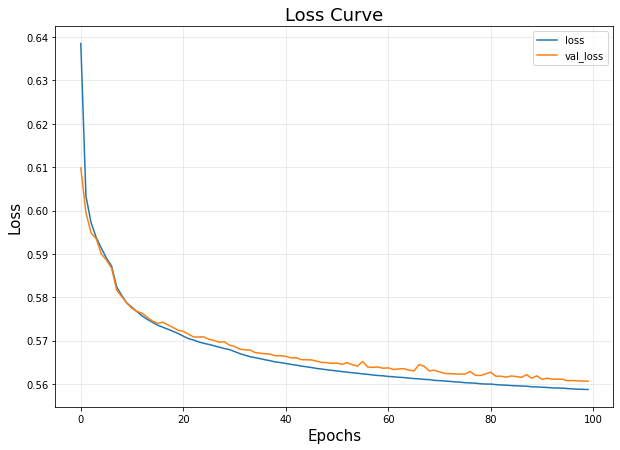

In [89]:
f = plt.figure(figsize=(10,7))
f.add_subplot()
#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("VAE_Loss_Trial5.png")
plt.show()



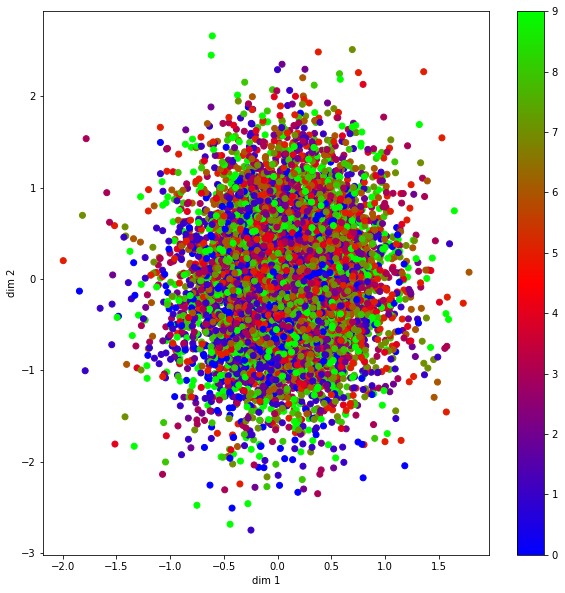

<Figure size 432x288 with 0 Axes>

In [90]:
mu, _, _ = encoder.predict(xtest)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=ytest, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()
plt.savefig("VAE_Colourbar_Trial5.png")


In [91]:
#RANDOM GENERATION
def generate():
    n=20
    figure = np.zeros((width *2 , height * 10, channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space

    for k in range(2):
        for l in range(10):
            z_sample =random.rand(3072)
            z_out=np.array([z_sample])
            x_decoded = decoder.predict(z_out)
            digit = x_decoded[0].reshape(width, height, channels)
            figure[k * width: (k + 1) * width,
                    l * height: (l + 1) * height] = digit

    plt.figure(figsize=(10, 10))
#Reshape for visualization
    fig_shape = np.shape(figure)
    figure = figure.reshape((fig_shape[0], fig_shape[1],3))

    plt.imshow(figure, cmap='gnuplot2')
    plt.show()  
 
    plt.savefig("VAE_imagesgen_Trial5.png")


In [92]:
#IMAGE RECONSTRUCT USING TEST SET IMGS
def reconstruct():
    num_imgs = 6
    rand = np.random.randint(1, xtest.shape[0]-6) 

    xtestsample = xtest[rand:rand+num_imgs]
    x_encoded = np.array(encoder.predict(xtestsample))
    latent_xtest=x_encoded[2]
    x_decoded = decoder.predict(latent_xtest)

    rows = 2 # defining no. of rows in figure
    cols = 3 # defining no. of colums in figure
    cell_size = 1.5
    f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
    f.tight_layout()
    for i in range(rows):
        for j in range(cols): 
            f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
            plt.imshow(xtestsample[i*cols + j]) 
            plt.axis("off")
        
        for j in range(cols): 
            f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
            plt.imshow(x_decoded[i*cols + j]) 
            plt.axis("off")

    f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
    plt.savefig("VAE_imagesrecons_Trial5.png")

    plt.show()


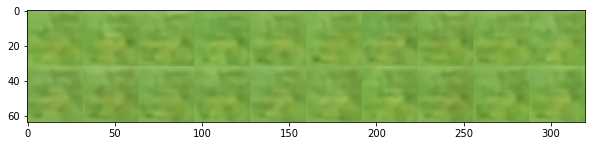

<Figure size 432x288 with 0 Axes>

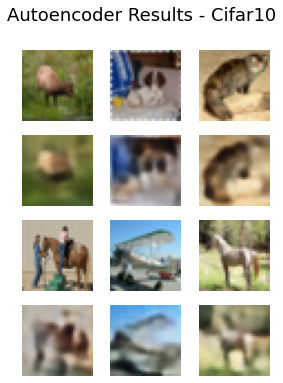

In [93]:
generate()
reconstruct()